<h3> Summary of this notebook: </h3>

- Now we move from word-based embeddings to BPE-based embeddings

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Concatenate, LSTM, Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/ColabNotebooks/train_translate

In [2]:
from model_components import preprocess_sentence, get_angles, positional_encoding, create_padding_mask, create_look_ahead_mask, \
                                FullyConnected, EncoderLayer, Encoder, DecoderLayer, Decoder, Transformer, CustomSchedule, \
                                    create_train_tokenizer, load_tokenizer

In [3]:
from translate_helper_functions import translate, random_translate_from_tensor, plot_attention_weights

In [4]:
from tokenizers import Tokenizer, ByteLevelBPETokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing

In [5]:
# load BPE tokenizers with pre-trained weights
de_tokenizer, de_word_index = load_tokenizer('tokenizer_de_corpus.json')
en_tokenizer, en_word_index = load_tokenizer('tokenizer_en_corpus.json')

In [6]:
vocab_len_source = len(de_word_index.keys())
vocab_len_target = len(en_word_index.keys())
vocab_len_source, vocab_len_target

(29999, 29999)

In [7]:
num_tokens_source = vocab_len_source + 1
num_tokens_target = vocab_len_target + 1

In [8]:
# load source & train arrays from csv file:
source_train_tensor = np.loadtxt('source_train_tensor.csv', delimiter = ',')
source_test_tensor = np.loadtxt('source_test_tensor.csv', delimiter = ',')
target_train_tensor = np.loadtxt('target_train_tensor.csv', delimiter = ',')
target_test_tensor = np.loadtxt('target_test_tensor.csv', delimiter = ',')

In [9]:
max_source_length= max(len(t) for t in source_train_tensor)
max_target_length= max(len(t) for t in  target_train_tensor)

In [10]:
max_source_length, max_target_length

(43, 35)

<h3> Define arguments for Transformer </h3>

- These needs to be same as the ones used during training

In [11]:
# Transformer arguments: 
# num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
# target_vocab_size, max_positional_encoding_input,
# max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6

num_layers = 4
embedding_dim = 64
num_heads = 5
fully_connected_dim = 128
input_vocab_size = num_tokens_source
target_vocab_size = num_tokens_target
max_positional_encoding_input = max_source_length
max_positional_encoding_target = max_target_length

- Create transformer object before loading saved weights

In [12]:
transformer = Transformer(
    num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target
    )

file_path = 'saved_models/model'
transformer.load_weights(file_path)

(1, 43, 64)
(1, 35, 64)


In [13]:
pred_sentence, original_sentence, attention_weights = random_translate_from_tensor(transformer, de_tokenizer, en_tokenizer, 
                                                                                        source_train_tensor, target_train_tensor, max_target_length)

Input: Tom lebt von der Hand in den Mund.
Predicted translation: Tom lives from hand to mouth.
Actual translation: Tom lives from hand to mouth.


In [ ]:
pred_sentence = pred_sentence
input_sentence = original_sentence 
attention_weights = attention_weights
de_tokenizer = de_tokenizer
en_tokenizer = en_tokenizer


input_encoding = de_tokenizer.encode(input_sentence)
input_tokens = input_encoding.tokens
len_input = len(input_tokens)

output_encoding = en_tokenizer.encode(pred_sentence)
output_tokens = output_encoding.tokens
# Want to ignore "start_" token, since it is not included in the attention plot
output_tokens = output_tokens[1:]

# retrieve final key of dictionary – this corresponds to the final decoder layer, block 2 (decoder-encoder mha)
final_block_decenc = list(attention_weights.keys())[-1]

# retrieve final attention block
attention_block = attention_weights[final_block_decenc]     # attention_weights is a dictionary
                                                            # attention_block = (1, num_heads, len(pred_sentence), Tx)
attention_block_squeezed = tf.squeeze(attention_block, 0)   # attention_block_squeezed = (num_heads, len(pred_sentence), Tx)
num_heads = attention_block_squeezed.shape[0]

fig, ax = plt.subplots(num_heads, 1, figsize = (14,14))

for head in range (num_heads):
    temp_attn_block = attention_block_squeezed[head]
    temp_attn_block = np.around(temp_attn_block, 3)
    ax[head].set_title(f'Head {head + 1}')
    sns.heatmap(temp_attn_block[:,:len_input], ax = ax[head], cmap = 'hot', annot = True, xticklabels = input_tokens, yticklabels = output_tokens)


plt.tight_layout()
plt.savefig('./static/attention_plots.png')

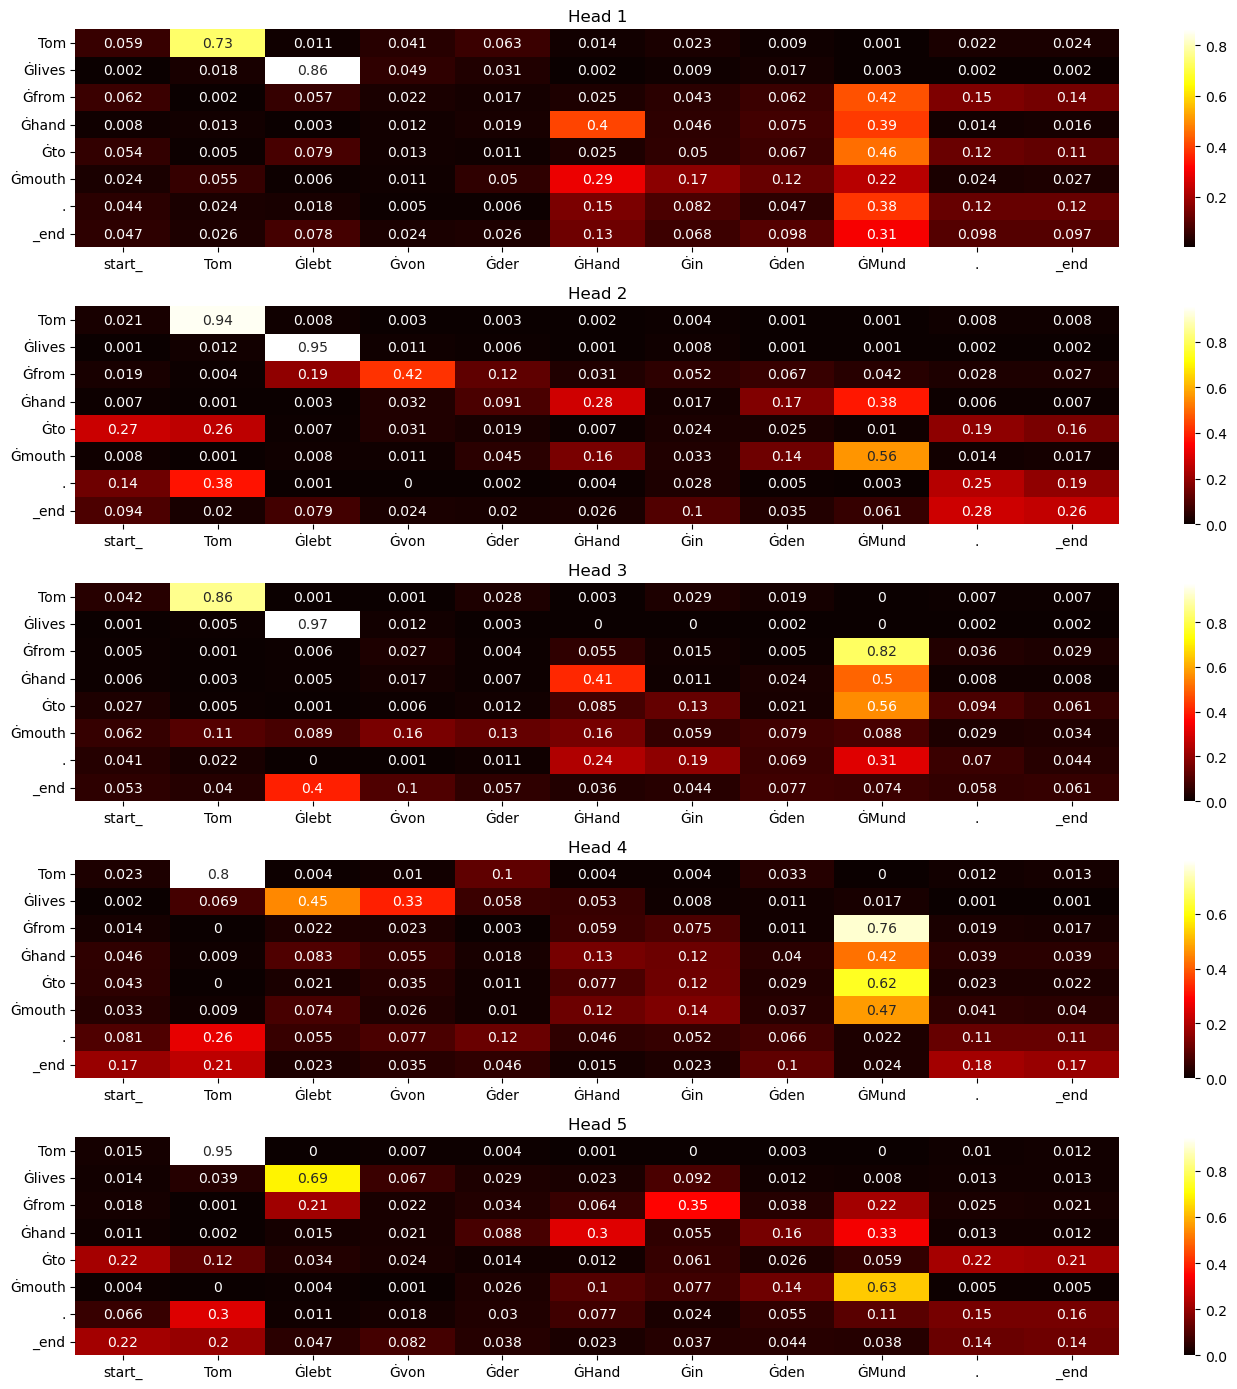

In [15]:
fig = plot_attention_weights(pred_sentence, original_sentence, attention_weights, de_tokenizer, en_tokenizer)

In [19]:
sent_1 = 'Tom muss nach Hause gehen'
pred_sentence, original_sentence, attention_weights = translate(sent_1, transformer, max_target_length, de_tokenizer, en_tokenizer)
pred_sentence, original_sentence

('Tom must leave home.', 'Tom muss nach Hause gehen')

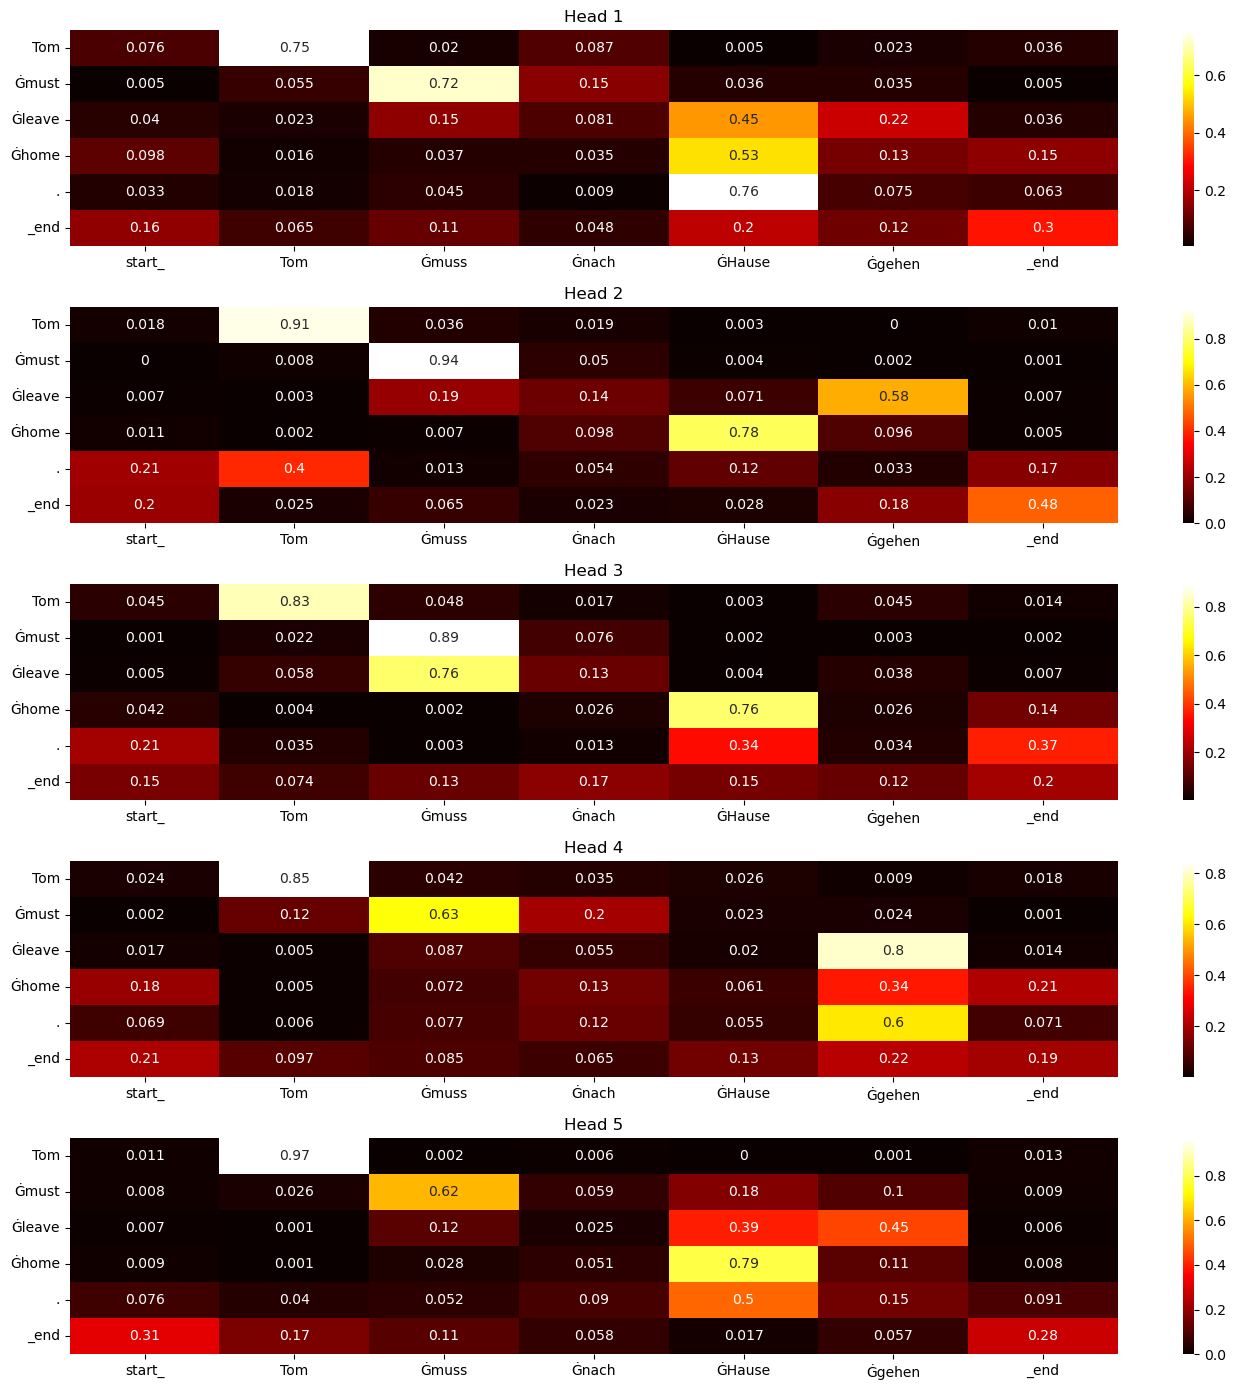

In [20]:
plot_attention_weights(pred_sentence, original_sentence, attention_weights, de_tokenizer, en_tokenizer)